<a href="https://colab.research.google.com/github/s-i-d-h-u/upi-secure/blob/main/UPI_SECURE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
pip install pandas numpy scikit-learn scipy hmmlearn joblib huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 3.4 MB/s eta 0:00:00


In [ ]:
!pip install pandas numpy scikit-learn matplotlib seaborn

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans

def preprocess_data(file_path):
    # Load dataset
    df = pd.read_csv(file_path)

    # Drop duplicate records
    df = df.drop_duplicates()

    # Handle missing values (drop for now)
    df = df.dropna()

    # Feature Scaling for numerical values
    scaler = StandardScaler()
    numerical_features = ['Transaction Amount (INR)', 'Avg_Transaction_Amount', 'Transaction_Frequency', 'Time_Anomaly', 'Past_Transactions']
    df[numerical_features] = scaler.fit_transform(df[numerical_features])

    # Encoding categorical feature (Fraud_Type)
    encoder = LabelEncoder()
    df['Fraud_Type'] = encoder.fit_transform(df['Fraud_Type'])

    # Convert Timestamp to datetime & extract time-based features
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['hour'] = df['Timestamp'].dt.hour
    df['day_of_week'] = df['Timestamp'].dt.dayofweek

    # Extract Latitude & Longitude from Location and apply Clustering
    df[['Latitude', 'Longitude']] = df['Location'].str.extract(r'\(([^,]+), ([^)]+)\)').astype(float)

    # KMeans Clustering for Location Features
    kmeans = KMeans(n_clusters=5, random_state=42)  # 5 clusters (adjustable)
    df['Location_Cluster'] = kmeans.fit_predict(df[['Latitude', 'Longitude']])

    # Drop unnecessary columns
    df = df.drop(columns=['Location', 'Timestamp', 'Latitude', 'Longitude'])

    # Save the processed dataset
    df.to_csv('processed_upi_dataset.csv', index=False)
    print("Preprocessing complete. Processed dataset saved.")

    return df

# Example usage
file_path = 'new_dataset.csv'
processed_df = preprocess_data(file_path)

Preprocessing complete. Processed dataset saved.


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def extract_features(file_path):
    # Load the preprocessed dataset
    df = pd.read_csv(file_path)

    # Derived Features
    df['Transaction_Amount_Diff'] = df['Transaction Amount (INR)'] - df['Avg_Transaction_Amount']
    df['Transaction_Frequency_Score'] = df['Transaction_Frequency'] * df['Past_Transactions']
    df['Time_Anomaly_Score'] = df['Time_Anomaly'] * df['Transaction Amount (INR)']

    # Aggregate Features based on Recipient ID
    df['Recipient_Total_Transactions'] = df.groupby('Recipient ID')['Transaction ID'].transform('count')
    df['Recipient_Avg_Transaction_Amount'] = df.groupby('Recipient ID')['Transaction Amount (INR)'].transform('mean')

    # Feature interaction
    df['Risk_Score'] = (
        df['Transaction_Frequency_Score'] +
        df['Time_Anomaly_Score'] -
        df['Recipient_Total_Transactions']
    )

    # Retain relevant columns
    feature_columns = [
        'Transaction Amount (INR)', 'Transaction_Amount_Diff',
        'Transaction_Frequency_Score', 'Time_Anomaly_Score',
        'Recipient_Total_Transactions', 'Recipient_Avg_Transaction_Amount',
        'Fraud_Type', 'Risk_Score', 'hour', 'day_of_week', 'Location_Cluster'
    ]

    # Final feature dataframe
    feature_df = df[feature_columns]

    # Split dataset into Train (80%) & Test (20%)
    train_df, test_df = train_test_split(feature_df, test_size=0.2, random_state=42, stratify=df['Fraud_Type'])

    # Save train & test datasets
    train_df.to_csv('train_features.csv', index=False)
    test_df.to_csv('test_features.csv', index=False)

    print("Feature extraction complete.")
    print("Training set saved as 'train_features.csv'.")
    print("Test set saved as 'test_features.csv'.")

    return train_df, test_df

# Example usage
file_path = 'processed_upi_dataset.csv'
train_features, test_features = extract_features(file_path)


Feature extraction complete.
Training set saved as 'train_features.csv'.
Test set saved as 'test_features.csv'.


In [4]:
!pip install sklearn-crfsuite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.1 MB/s eta 0:00:00


In [6]:
import os
import numpy as np
import pandas as pd
import joblib
from hmmlearn import hmm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import sklearn_crfsuite

# Load preprocessed dataset
df = pd.read_csv("train_features.csv")

# --- Remap the labels ---
# Original Fraud_Type values: [0, 1, 2, 3, 4]
# New mapping: 0 stays 0; 1 and 2 become 1; 3 and 4 become 2.
mapping = {0: 0, 1: 1, 2: 1, 3: 2, 4: 2}
df['Fraud_Type'] = df['Fraud_Type'].map(mapping)

# Verify new unique classes
print("Unique Fraud_Type after mapping:", df['Fraud_Type'].unique())

# Split into train and test sets (80-20 split)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Prepare Features (X) and Labels (y)
feature_columns = [col for col in df.columns if col not in ['Fraudulent', 'Fraud_Type']]
X_train = train_df[feature_columns].values
y_train = train_df['Fraud_Type'].values  # Target labels: Normal, Suspicious, Fraud

# Encode Labels (0: Normal, 1: Suspicious, 2: Fraud)
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)

# Scale features for better performance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# --- Auto-Regressive HMM Training ---
n_components = 3  # Normal, Suspicious, Fraud
n_lags = 3  # Number of previous observations used for AR modeling

# Create a new feature set with lagged observations
X_ar_train = []
for i in range(n_lags, len(X_train)):
    X_ar_train.append(np.hstack([X_train[i - j] for j in range(n_lags)]))

X_ar_train = np.array(X_ar_train)
y_ar_train = y_train[n_lags:]  # Adjust target labels

# Train the AR-HMM model
arlg_hmm = hmm.GaussianHMM(n_components=n_components, covariance_type="diag", n_iter=100)
arlg_hmm.fit(X_ar_train)

# --- CRF Training ---
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)

# Convert X_train into sequence format for CRF
X_train_seq = []
for data_point in X_train:
    feature_dict = {feature_columns[i]: value for i, value in enumerate(data_point)}
    X_train_seq.append([feature_dict])  # Encapsulate in a list to represent a sequence

# Convert y_train into sequences (string format required for CRF)
y_train_seq = [[str(y)] for y in y_train]

# Fit CRF
crf.fit(X_train_seq, y_train_seq)

# Create models directory if it does not exist
if not os.path.exists("models"):
    os.makedirs("models")

# Save models
joblib.dump(arlg_hmm, "models/arlg_hmm_model.pkl")  # Save AR-HMM
joblib.dump(crf, "models/crf_model.pkl")  # Save CRF
joblib.dump(scaler, "models/scaler.pkl")  # Save Scaler
joblib.dump(label_encoder, "models/label_encoder.pkl")  # Save Label Encoder

print("✅ Auto-Regressive HMM + CRF Model training complete! All models saved in 'models' directory.")


Unique Fraud_Type after mapping: [2 0 1]
✅ Auto-Regressive HMM + CRF Model training complete! All models saved in 'models' directory.



🚀 Final (Hybrid ARLG-HMM + CRF) Model Performance:
   ✅ Accuracy: 0.6915
   ✅ Precision: 0.6830
   ✅ Recall: 0.6915
   ✅ F1-Score: 0.6822


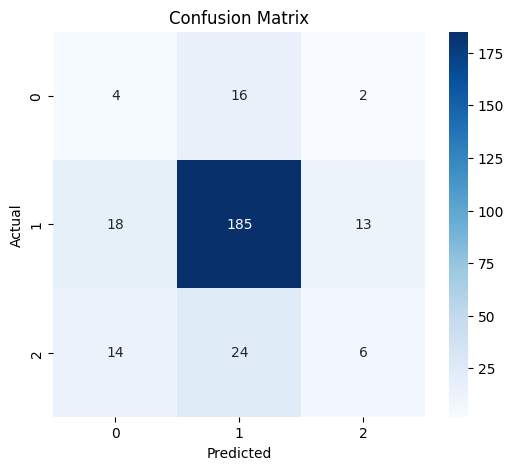

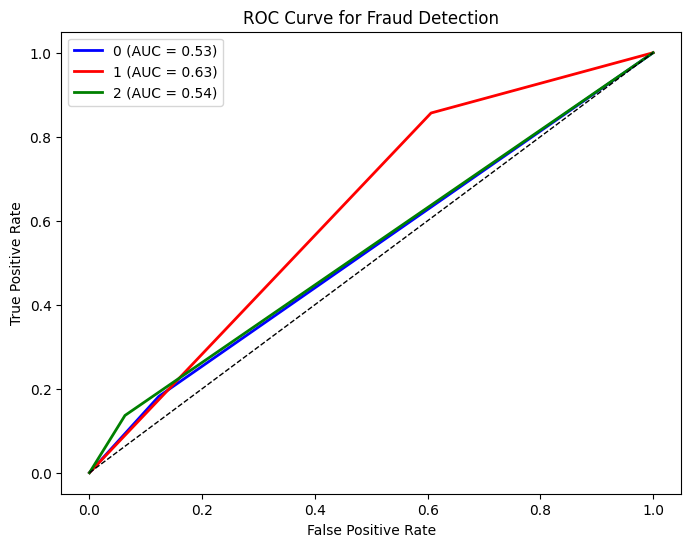

In [8]:
import os
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc
)
from hmmlearn import hmm
import sklearn_crfsuite
from itertools import cycle

# Load test dataset
df_test = pd.read_csv("test_features.csv")

mapping = {0: 0, 1: 1, 2: 1, 3: 2, 4: 2}
df_test['Fraud_Type'] = df_test['Fraud_Type'].map(mapping)

# Load preprocessing tools
scaler = joblib.load("models/scaler.pkl")
label_encoder = joblib.load("models/label_encoder.pkl")

# Prepare test features (X) and labels (y)
feature_columns = [col for col in df_test.columns if col not in ['Fraudulent', 'Fraud_Type']]
X_test = df_test[feature_columns].values
y_test = label_encoder.transform(df_test['Fraud_Type'].values)

# Scale test features
X_test = scaler.transform(X_test)

# Load trained models
arlg_hmm = joblib.load("models/arlg_hmm_model.pkl")
crf = joblib.load("models/crf_model.pkl")

# --- Apply lagging to the test data to match the training data shape ---
n_lags = 3  # Same n_lags used during training
X_ar_test = []
for i in range(n_lags, len(X_test)):
    X_ar_test.append(np.hstack([X_test[i - j] for j in range(n_lags)]))

X_ar_test = np.array(X_ar_test)
y_test_adjusted = y_test[n_lags:]  # Adjust target labels to match lagged data

# Predict using ARLG-HMM with lagged test data
hmm_predictions = arlg_hmm.predict(X_ar_test)
state_to_label = {0: 0, 1: 1, 2: 2}  # Assuming 0=Normal, 1=Suspicious, 2=Fraud
hmm_pred_labels = np.vectorize(state_to_label.get)(hmm_predictions)


# Prepare test data for CRF
X_test_seq = [[{feature_columns[i]: value for i, value in enumerate(data_point)}] for data_point in X_test]
crf_pred_labels = np.array([int(label[0]) for label in crf.predict(X_test_seq)])

# Adjust CRF predictions to match the length of HMM predictions
crf_pred_labels_adjusted = crf_pred_labels[n_lags:]

# Final Ensemble Decision (using adjusted labels)
final_pred_labels = np.where(hmm_pred_labels == crf_pred_labels_adjusted, hmm_pred_labels, crf_pred_labels_adjusted)

# Compute Metrics (using adjusted y_test)
final_accuracy = accuracy_score(y_test_adjusted, final_pred_labels)
final_precision, final_recall, final_f1, _ = precision_recall_fscore_support(
    y_test_adjusted, final_pred_labels, average='weighted', zero_division=1
)

print(f"\n🚀 Final (Hybrid ARLG-HMM + CRF) Model Performance:")
print(f"   ✅ Accuracy: {final_accuracy:.4f}")
print(f"   ✅ Precision: {final_precision:.4f}")
print(f"   ✅ Recall: {final_recall:.4f}")
print(f"   ✅ F1-Score: {final_f1:.4f}")

# --- Confusion Matrix ---
labels = label_encoder.classes_
cm = confusion_matrix(y_test_adjusted, final_pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# --- ROC Curve ---
y_test_bin = np.eye(len(labels))[y_test_adjusted]  # One-hot encode y_test_adjusted
final_pred_bin = np.eye(len(labels))[final_pred_labels]
plt.figure(figsize=(8, 6))
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(len(labels)), colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], final_pred_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label=f"{labels[i]} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Fraud Detection")
plt.legend()
plt.show()